# Bias in embeddings trained from scratch:
## *Where does bias in embeddings come from?*

Notebook contents:
1. Summary of bias metrics in the existing literature
2. Training of word2vec on different training datasets (of varying sizes and sources)
3. Visualizations and computations of bias metrics

## 1. Bias metrics in the existing literature

There are 3 prominent metrics in the literature (among others): projection of word embeddings along a gender direction (Bolukbasi, modified by Nissim), WEAT, and WEFAT (Caliskan, Bryson, Narayanan). Below we summarize these papers.

#### 1. Bolukbasi et al. (NIPS 2016): "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings" https://arxiv.org/abs/1607.06520

#### 2. Nissim, van Noord, and van der Goot (2019): "Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor" https://arxiv.org/abs/1905.09866

#### 3. Caliskan, Bryson, and Narayanan (Science 2017): "Semantics derived automatically from language corpora contain human-like biases" https://purehost.bath.ac.uk/ws/portalfiles/portal/168480066/CaliskanEtAl_authors_full.pdf

* IAT is one technique used (outside of word embeddings) to measure implicit human biases:
    * "Implicit Association Test": assessment (on humans) introduced by Greenwald et al., where a word is categorized into one of two categories, and faster reaction time is considered as more deeply rooted association
* Introduces new statistical test **WEAT** (Word Embedding Association Test) to measure biases in word embeddings
    * analogous to the IAT: interpretation is "how separated the two distributions (of associations between target and attribute) are"
    * inputs:
        * 2 sets of target words:
            * X. programmer/engineer/scientist/...
            * Y. nurse/teacher/librarian/...) 
        * 2 sets of attribute words:
            * A. man/male/...
            * B. woman/female/...):
    * test statistic:
        * intuitively, difference between association of two sets of target words, with attributes
        * $s(X, Y, A, B) = \sum_{x \in X} s(x, A, B) - \sum_{y \in Y} s(y, A, B)$
        * $s(w, A, B) = mean_{a \in A} cos(w, a) - mean_{b \in B} cos(w, b)$
    * p-value of permutation test (permuting target words)
        * $Pr_i[s(X_i, Y_i, A, B) > s(X, Y, A, B)]$
        * effect size: $\frac{mean_{x \in X} s(x, A, B) - mean_{y \in Y} s(y, A, B)}{sd_{w \in X \bigcup Y} s(w, A, B)}$
    * Obtains similar results to original finding in Greenwald et al.
* Introduces **WEFAT** (Word Embedding Factual Association Test):
    * instead of using target word embeddings, use real-valued factual property, e.g. % female workers in occupation)
    * difference in avg. cos similarity (between attribute A and target property, vs. attribute B and target property), divided by standard deviation of cos similarity (across each combination of attribute - target property) 
    * high correlation between % of women in different occupations, vs. strength of association of word vector w/ female gender

## 2. word2vec model training from scratch

####  Dataset grid:
Training size: 
* {10k, 15k, 20k, 25k, 30k}

Text source:
* TweetEval: labeled tweet dataset (e.g. sentiment, hate, emotion): https://huggingface.co/datasets/tweet_eval
* Reddit: unlabeled reddit post dataset: https://huggingface.co/datasets/reddit
* CNN/DailyMail: news article text with highlights: https://huggingface.co/datasets/cnn_dailymail

*Potential future extensions:*
* Historical texts (unfortunately most of these are not freely available):
     * Pretrained historical word vectors: pre-trained word vectors trained on historical books from various decades from 1880s - 1990s: https://nlp.stanford.edu/projects/histwords/
     * The New York Times Annotated Corpus: articles with metadata from 1987-2007: https://catalog.ldc.upenn.edu/LDC2008T19
     * informal private letters by British writers, covering the period 1861 to 1919 (available here: http://www.llc.manchester.ac.uk/subjects/lel/staff/david-denison/lmode-prose/)

In [35]:
from typing import Tuple, Dict, List
import re
from datasets import load_dataset
from os.path import exists
import numpy as np
import random
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

# Set global parameters:
STEM = False # whether to stem words during tokenization
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~—“”'
ss = SnowballStemmer('english')
sw = stopwords.words('english')
LR = 0.01
EPOCHS = 15
WINDOW = 5 # context window for CBOW
MIN_COUNT = 5 # ignore words w fewer than MIN_COUNT counts
REMOVE_STOPWORDS = False
SUBSET_RANDOMLY = False # whether to randomly subset the data, or by index

# Text preprocessing functions:
def remove_punc(text: str, punc: str) -> str:
    return text.translate({ord(p):'' for p in punc})

def split_on_whitespace(text: str) -> List[str]:
    if text: return re.split('\s+', text)
    else: return []

def tokenize(text: str, punc: str, stem = STEM, remove_stopwords = REMOVE_STOPWORDS) -> List[str]:
    tokens = [i for i in split_on_whitespace(remove_punc(text, punc).lower()) if len(i)]
    if remove_stopwords:
        tokens = [i for i in tokens if i not in sw]
    if stem:
        return [ss.stem(i) for i in tokens]
    return tokens

def load_corpus(texts: List[str], punc: str) -> List[List[str]]:
    tokenized_docs = []
    for t in texts:
        tokenized_docs.append(tokenize(t, punc))
    return tokenized_docs

# Callback for printing loss after each epoch when training word2vec with gensim:
# https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.prev_loss = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        cur_loss = loss - self.prev_loss
        self.prev_loss = loss
        print('Loss after epoch {}: {}'.format(self.epoch, cur_loss))
        self.epoch += 1
        
# Obtain list with one text string per document, using huggingface dataset
def get_data(dataset_name, max_records = 5000, subset_randomly = SUBSET_RANDOMLY):
    if dataset_name == "tweet_eval":
        dataset = load_dataset(dataset_name, "sentiment")
        X_train = dataset['train']['text']
        X_train = [i.replace('@user', '') for i in X_train] #strip @ mentions
    elif dataset_name == "reddit":
        dataset = load_dataset(dataset_name)
        X_train = dataset['train']['normalizedBody']
    elif dataset_name == "cnn_dailymail":
        dataset = load_dataset(dataset_name, '3.0.0')
        X_train = dataset['train']['article']
    else:
        raise NotImplementedError("Specified dataset not recognized.")
        
    if subset_randomly:
        # Set seed for random subsetting of data (to reduce training set to make training feasible)
        random.seed(1)
        X_train = random.sample(X_train, max_records)
    else:
        X_train = X_train[:max_records]
    return X_train

In [36]:
# CREATE ALL EMBEDDINGS IF THEY DO NOT ALREADY EXIST
datasets = ["tweet_eval", "reddit", "cnn_dailymail"]
sizes = [10000, 15000, 20000, 25000, 30000]

for d in datasets:
    for s in sizes:
        print(f"Dataset {d}, size {s}")
        EMBEDDINGS_FILE = f'data/{d}_{s}_vectors.kv' # file directory of local embeddings file
        if exists(EMBEDDINGS_FILE):
            pass
        else:
            print(f"{EMBEDDINGS_FILE} not found. Training word vectors on {d} dataset...")
            X_train = get_data(d, max_records = s)
            # Create list of lists (of tokens)
            # each element of the list is a document (e.g. tweet, news article, etc.)
            full_tokenized = load_corpus(X_train, punc)
            # Instantiate and train word2vec model
            model = Word2Vec(sentences = full_tokenized, 
                         size = 100, 
                         window = WINDOW, 
                         min_count = MIN_COUNT, 
                         workers = 8,
                         alpha = LR, # learning rate
                         iter = EPOCHS, # number of epochs
                         compute_loss=True, 
                         callbacks=[callback()])
            word_vectors = model.wv
            word_vectors.save(EMBEDDINGS_FILE)
            print(f"Finished training. Saved embeddings to {EMBEDDINGS_FILE}.")

Dataset tweet_eval, size 10000
data/tweet_eval_10000_vectors.kv not found. Training word vectors on tweet_eval dataset...


Reusing dataset tweet_eval (/home/morrisreeves/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 81169.609375
Loss after epoch 1: 64588.21875
Loss after epoch 2: 58076.53125
Loss after epoch 3: 57554.09375
Loss after epoch 4: 37352.953125
Loss after epoch 5: 50286.53125
Loss after epoch 6: 37287.5625
Loss after epoch 7: 55481.34375
Loss after epoch 8: 49057.71875
Loss after epoch 9: 54970.8125
Loss after epoch 10: 48477.4375
Loss after epoch 11: 54481.125
Loss after epoch 12: 36397.875
Loss after epoch 13: 53934.625
Loss after epoch 14: 53845.875
Finished training. Saved embeddings to data/tweet_eval_10000_vectors.kv.
Dataset tweet_eval, size 15000
data/tweet_eval_15000_vectors.kv not found. Training word vectors on tweet_eval dataset...


Reusing dataset tweet_eval (/home/morrisreeves/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 106112.640625
Loss after epoch 1: 84214.296875
Loss after epoch 2: 79961.5625
Loss after epoch 3: 79035.03125
Loss after epoch 4: 57706.1875
Loss after epoch 5: 76413.5
Loss after epoch 6: 75096.21875
Loss after epoch 7: 75060.6875
Loss after epoch 8: 74408.75
Loss after epoch 9: 74069.25
Loss after epoch 10: 73201.9375
Loss after epoch 11: 73406.9375
Loss after epoch 12: 72144.8125
Loss after epoch 13: 72503.9375
Loss after epoch 14: 71778.0
Finished training. Saved embeddings to data/tweet_eval_15000_vectors.kv.
Dataset tweet_eval, size 20000
data/tweet_eval_20000_vectors.kv not found. Training word vectors on tweet_eval dataset...


Reusing dataset tweet_eval (/home/morrisreeves/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 131389.59375
Loss after epoch 1: 83684.171875
Loss after epoch 2: 100672.984375
Loss after epoch 3: 99139.53125
Loss after epoch 4: 116537.34375
Loss after epoch 5: 95592.625
Loss after epoch 6: 113297.8125
Loss after epoch 7: 93656.5625
Loss after epoch 8: 92422.5625
Loss after epoch 9: 91316.75
Loss after epoch 10: 90874.5625
Loss after epoch 11: 90851.875
Loss after epoch 12: 90128.625
Loss after epoch 13: 89975.25
Loss after epoch 14: 88987.0
Finished training. Saved embeddings to data/tweet_eval_20000_vectors.kv.
Dataset tweet_eval, size 25000
data/tweet_eval_25000_vectors.kv not found. Training word vectors on tweet_eval dataset...


Reusing dataset tweet_eval (/home/morrisreeves/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 155324.640625
Loss after epoch 1: 125175.359375
Loss after epoch 2: 121420.6875
Loss after epoch 3: 132998.5
Loss after epoch 4: 135568.375
Loss after epoch 5: 133335.875
Loss after epoch 6: 112440.75
Loss after epoch 7: 111452.4375
Loss after epoch 8: 128062.875
Loss after epoch 9: 127017.5
Loss after epoch 10: 107662.375
Loss after epoch 11: 120498.375
Loss after epoch 12: 106416.5
Loss after epoch 13: 106098.125
Loss after epoch 14: 105973.5
Finished training. Saved embeddings to data/tweet_eval_25000_vectors.kv.
Dataset tweet_eval, size 30000
data/tweet_eval_30000_vectors.kv not found. Training word vectors on tweet_eval dataset...


Reusing dataset tweet_eval (/home/morrisreeves/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 206263.3125
Loss after epoch 1: 146566.125
Loss after epoch 2: 161657.75
Loss after epoch 3: 138034.625
Loss after epoch 4: 134797.25
Loss after epoch 5: 151267.0
Loss after epoch 6: 130265.9375
Loss after epoch 7: 146611.75
Loss after epoch 8: 126259.125
Loss after epoch 9: 124818.5
Loss after epoch 10: 141621.25
Loss after epoch 11: 140482.0
Loss after epoch 12: 139241.25
Loss after epoch 13: 121533.875
Loss after epoch 14: 121431.25
Finished training. Saved embeddings to data/tweet_eval_30000_vectors.kv.
Dataset reddit, size 10000
data/reddit_10000_vectors.kv not found. Training word vectors on reddit dataset...


Using custom data configuration default
Reusing dataset reddit (/home/morrisreeves/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969)


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after epoch 0: 624850.8125
Loss after epoch 1: 541240.6875
Loss after epoch 2: 518418.875
Loss after epoch 3: 520263.875
Loss after epoch 4: 492121.5
Loss after epoch 5: 491071.75
Loss after epoch 6: 455827.0
Loss after epoch 7: 448421.75
Loss after epoch 8: 424163.75
Loss after epoch 9: 387162.5
Loss after epoch 10: 401110.0
Loss after epoch 11: 398371.5
Loss after epoch 12: 384173.5
Loss after epoch 13: 370357.0
Loss after epoch 14: 379962.5
Finished training. Saved embeddings to data/reddit_10000_vectors.kv.
Dataset reddit, size 15000
data/reddit_15000_vectors.kv not found. Training word vectors on reddit dataset...


Using custom data configuration default
Reusing dataset reddit (/home/morrisreeves/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969)


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after epoch 0: 923970.6875
Loss after epoch 1: 803817.3125
Loss after epoch 2: 744533.25
Loss after epoch 3: 734396.0
Loss after epoch 4: 734361.0
Loss after epoch 5: 615827.25
Loss after epoch 6: 610612.5
Loss after epoch 7: 608734.0
Loss after epoch 8: 580065.5
Loss after epoch 9: 590639.5
Loss after epoch 10: 568724.0
Loss after epoch 11: 557485.0
Loss after epoch 12: 513104.0
Loss after epoch 13: 466200.0
Loss after epoch 14: 509183.0
Finished training. Saved embeddings to data/reddit_15000_vectors.kv.
Dataset reddit, size 20000
data/reddit_20000_vectors.kv not found. Training word vectors on reddit dataset...


Using custom data configuration default
Reusing dataset reddit (/home/morrisreeves/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969)


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after epoch 0: 1213925.875
Loss after epoch 1: 1017907.125
Loss after epoch 2: 938734.0
Loss after epoch 3: 957877.5
Loss after epoch 4: 800024.5
Loss after epoch 5: 777472.5
Loss after epoch 6: 775326.5
Loss after epoch 7: 734074.0
Loss after epoch 8: 761976.0
Loss after epoch 9: 719340.0
Loss after epoch 10: 635391.0
Loss after epoch 11: 640706.0
Loss after epoch 12: 638106.0
Loss after epoch 13: 621641.0
Loss after epoch 14: 641133.0
Finished training. Saved embeddings to data/reddit_20000_vectors.kv.
Dataset reddit, size 25000
data/reddit_25000_vectors.kv not found. Training word vectors on reddit dataset...


Using custom data configuration default
Reusing dataset reddit (/home/morrisreeves/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969)


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after epoch 0: 1383282.25
Loss after epoch 1: 1261543.0
Loss after epoch 2: 1140739.25
Loss after epoch 3: 1068754.0
Loss after epoch 4: 970101.0
Loss after epoch 5: 980668.5
Loss after epoch 6: 967201.0
Loss after epoch 7: 937965.0
Loss after epoch 8: 825793.0
Loss after epoch 9: 810360.0
Loss after epoch 10: 799678.0
Loss after epoch 11: 786340.0
Loss after epoch 12: 810301.0
Loss after epoch 13: 777092.0
Loss after epoch 14: 770493.0
Finished training. Saved embeddings to data/reddit_25000_vectors.kv.
Dataset reddit, size 30000
data/reddit_30000_vectors.kv not found. Training word vectors on reddit dataset...


Using custom data configuration default
Reusing dataset reddit (/home/morrisreeves/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969)


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after epoch 0: 1721372.0
Loss after epoch 1: 1482967.5
Loss after epoch 2: 1364776.0
Loss after epoch 3: 1171010.5
Loss after epoch 4: 1169889.5
Loss after epoch 5: 1121304.0
Loss after epoch 6: 1044941.5
Loss after epoch 7: 999740.0
Loss after epoch 8: 1019834.0
Loss after epoch 9: 992997.0
Loss after epoch 10: 948251.0
Loss after epoch 11: 963109.0
Loss after epoch 12: 967819.0
Loss after epoch 13: 938734.0
Loss after epoch 14: 935927.0
Finished training. Saved embeddings to data/reddit_30000_vectors.kv.
Dataset cnn_dailymail, size 10000
data/cnn_dailymail_10000_vectors.kv not found. Training word vectors on cnn_dailymail dataset...


Reusing dataset cnn_dailymail (/home/morrisreeves/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 1773608.125
Loss after epoch 1: 1418314.125
Loss after epoch 2: 1290553.25
Loss after epoch 3: 1157386.0
Loss after epoch 4: 1072117.0
Loss after epoch 5: 1091712.5
Loss after epoch 6: 998952.0
Loss after epoch 7: 919930.0
Loss after epoch 8: 911533.0
Loss after epoch 9: 862651.0
Loss after epoch 10: 878155.0
Loss after epoch 11: 871800.0
Loss after epoch 12: 879351.0
Loss after epoch 13: 869842.0
Loss after epoch 14: 846925.0
Finished training. Saved embeddings to data/cnn_dailymail_10000_vectors.kv.
Dataset cnn_dailymail, size 15000
data/cnn_dailymail_15000_vectors.kv not found. Training word vectors on cnn_dailymail dataset...


Reusing dataset cnn_dailymail (/home/morrisreeves/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 2489228.0
Loss after epoch 1: 2038571.0
Loss after epoch 2: 1689467.5
Loss after epoch 3: 1632808.5
Loss after epoch 4: 1462967.0
Loss after epoch 5: 1350576.0
Loss after epoch 6: 1357243.0
Loss after epoch 7: 1356595.0
Loss after epoch 8: 1339159.0
Loss after epoch 9: 1337905.0
Loss after epoch 10: 1220936.0
Loss after epoch 11: 1114286.0
Loss after epoch 12: 1083964.0
Loss after epoch 13: 1095014.0
Loss after epoch 14: 1092542.0
Finished training. Saved embeddings to data/cnn_dailymail_15000_vectors.kv.
Dataset cnn_dailymail, size 20000
data/cnn_dailymail_20000_vectors.kv not found. Training word vectors on cnn_dailymail dataset...


Reusing dataset cnn_dailymail (/home/morrisreeves/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 3287844.25
Loss after epoch 1: 2466357.25
Loss after epoch 2: 2216276.0
Loss after epoch 3: 1946784.5
Loss after epoch 4: 1873104.0
Loss after epoch 5: 1799638.0
Loss after epoch 6: 1763523.0
Loss after epoch 7: 1741783.0
Loss after epoch 8: 1514092.0
Loss after epoch 9: 1547800.0
Loss after epoch 10: 1452978.0
Loss after epoch 11: 1508576.0
Loss after epoch 12: 1485870.0
Loss after epoch 13: 1437736.0
Loss after epoch 14: 1452152.0
Finished training. Saved embeddings to data/cnn_dailymail_20000_vectors.kv.
Dataset cnn_dailymail, size 25000
data/cnn_dailymail_25000_vectors.kv not found. Training word vectors on cnn_dailymail dataset...


Reusing dataset cnn_dailymail (/home/morrisreeves/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 3917512.25
Loss after epoch 1: 2839244.25
Loss after epoch 2: 2628709.5
Loss after epoch 3: 2303108.0
Loss after epoch 4: 2310062.0
Loss after epoch 5: 2271543.0
Loss after epoch 6: 1973289.0
Loss after epoch 7: 1906570.0
Loss after epoch 8: 1900844.0
Loss after epoch 9: 1856252.0
Loss after epoch 10: 1809808.0
Loss after epoch 11: 1839500.0
Loss after epoch 12: 1839530.0
Loss after epoch 13: 1787200.0
Loss after epoch 14: 1783856.0
Finished training. Saved embeddings to data/cnn_dailymail_25000_vectors.kv.
Dataset cnn_dailymail, size 30000
data/cnn_dailymail_30000_vectors.kv not found. Training word vectors on cnn_dailymail dataset...


Reusing dataset cnn_dailymail (/home/morrisreeves/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 4626698.0
Loss after epoch 1: 3355898.0
Loss after epoch 2: 2878135.0
Loss after epoch 3: 2775897.0
Loss after epoch 4: 2738693.0
Loss after epoch 5: 2365449.0
Loss after epoch 6: 2279854.0
Loss after epoch 7: 2264458.0
Loss after epoch 8: 2255464.0
Loss after epoch 9: 2202260.0
Loss after epoch 10: 2208028.0
Loss after epoch 11: 2230342.0
Loss after epoch 12: 1813160.0
Loss after epoch 13: 1147260.0
Loss after epoch 14: 1091504.0
Finished training. Saved embeddings to data/cnn_dailymail_30000_vectors.kv.


# 3. Visualization of bias metrics

Useful package to automatically compute bias metrics:
* automatic computation of the above bias metrics: https://docs.responsibly.ai/notebooks/demo-word-embedding-bias.html

The default pip install does not work.
To make it work:
* pip install gensim==3.7.1
* git clone https://github.com/ResponsiblyAI/responsibly.git
* cd responsibly
* delete the "python_requires" and "install_requires" arguments of responsibly/setup.py
* python setup.py install

In [37]:
from responsibly.we import calc_all_weat
import pandas as pd

In [38]:
# LOAD EMBEDDINGS AND CALCULATE METRICS
def get_results(query, datasets = datasets, sizes = sizes):
    results = {}
    for d in datasets:
        results[d] = ['']*len(sizes)
        for _i, s in enumerate(sizes):
            print(f"{d}, {s}")
            EMBEDDINGS_FILE = f'data/{d}_{s}_vectors.kv' # file directory of local embeddings file
            word_vectors = KeyedVectors.load(EMBEDDINGS_FILE)
            print(f"Loaded {EMBEDDINGS_FILE}.")
            # Sense check the trained word vectors...
            for w in ['woman', 'fire']:
                print(f"Most similar words to {w}:")
                display(word_vectors.most_similar(positive=[w], topn=5))
            try:
                result_df = calc_all_weat(word_vectors, filter_by='model', with_original_finding=False,
                                          with_pvalue=True, pvalue_kwargs={'method': 'approximate'})
                
                effect_size = result_df[result_df['Target words'] == query][['d']].values[0][0]
                results[d][_i] = effect_size
            except:
                print('Failed')
    output = pd.DataFrame.from_dict(results).T
    output.columns = sizes
    return output

In [39]:
# compute WEAT score in math vs. arts and science vs. arts comparisons, using Caliskan et al. (2016) word lists
math_arts = get_results('Math vs. Arts')
science_arts = get_results('Science vs. Arts')

tweet_eval, 10000
Loaded data/tweet_eval_10000_vectors.kv.
Most similar words to woman:


[('being', 0.9996429681777954),
 ('n', 0.999608039855957),
 ('part', 0.9995110034942627),
 ('barca', 0.9994152784347534),
 ('election', 0.9994141459465027)]

Most similar words to fire:


[('almost', 0.9997133016586304),
 ('williams', 0.9996799230575562),
 ('film', 0.9996669888496399),
 ('chelsea', 0.9996664524078369),
 ('halloween', 0.9996615648269653)]

Failed
tweet_eval, 15000
Loaded data/tweet_eval_15000_vectors.kv.
Most similar words to woman:


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


[('law', 0.9990522265434265),
 ('nokia', 0.9987666606903076),
 ('english', 0.9987127184867859),
 ('version', 0.9986815452575684),
 ('upon', 0.9985803961753845)]

Most similar words to fire:


[('sec', 0.9991708397865295),
 ('baseball', 0.9989045262336731),
 ('60', 0.9988649487495422),
 ('daughter', 0.9988501071929932),
 ('android', 0.9988458156585693)]

Failed
tweet_eval, 20000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/tweet_eval_20000_vectors.kv.
Most similar words to woman:


[('renewed', 0.9968104362487793),
 ('kid', 0.9940447807312012),
 ('english', 0.9938790798187256),
 ('goat', 0.9933728575706482),
 ('iu2019ve', 0.992448627948761)]

Most similar words to fire:


[('review', 0.9977714419364929),
 ('press', 0.9977639317512512),
 ('japan', 0.9976924061775208),
 ('independent', 0.9975099563598633),
 ('exclusive', 0.9974478483200073)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


tweet_eval, 25000
Loaded data/tweet_eval_25000_vectors.kv.
Most similar words to woman:


[('character', 0.9880375266075134),
 ('joke', 0.9864675998687744),
 ('lyrics', 0.9858841896057129),
 ('renewed', 0.985424280166626),
 ('clearly', 0.9830710887908936)]

Most similar words to fire:


[('led', 0.9962218999862671),
 ('web', 0.9955031871795654),
 ('frame', 0.9949183464050293),
 ('33', 0.9949009418487549),
 ('starring', 0.9945729970932007)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


tweet_eval, 30000
Loaded data/tweet_eval_30000_vectors.kv.
Most similar words to woman:


[('character', 0.9769243001937866),
 ('awful', 0.9665274024009705),
 ('kesha', 0.9612746834754944),
 ('written', 0.9606611728668213),
 ('word', 0.9589853882789612)]

Most similar words to fire:


[('outing', 0.9889519810676575),
 ('mtv', 0.9875917434692383),
 ('les', 0.9866175651550293),
 ('pavol', 0.986561119556427),
 ('assault', 0.9861032366752625)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


reddit, 10000
Loaded data/reddit_10000_vectors.kv.
Most similar words to woman:


[('girl', 0.886238694190979),
 ('guy', 0.8134366273880005),
 ('man', 0.7857657670974731),
 ('kid', 0.780749499797821),
 ('lady', 0.7801080346107483)]

Most similar words to fire:


[('box', 0.7959644198417664),
 ('crash', 0.781371533870697),
 ('highway', 0.7737804651260376),
 ('ball', 0.7687705755233765),
 ('roof', 0.7648351192474365)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


reddit, 15000
Loaded data/reddit_15000_vectors.kv.
Most similar words to woman:


[('girl', 0.8660507202148438),
 ('lady', 0.7810494899749756),
 ('man', 0.7584103941917419),
 ('kid', 0.7458174228668213),
 ('guy', 0.7353513240814209)]

Most similar words to fire:


[('ball', 0.7621542811393738),
 ('box', 0.7593377828598022),
 ('tower', 0.7506873607635498),
 ('air', 0.7365602850914001),
 ('tank', 0.7351988554000854)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


reddit, 20000
Loaded data/reddit_20000_vectors.kv.
Most similar words to woman:


[('girl', 0.8464751243591309),
 ('man', 0.7487219572067261),
 ('person', 0.74168860912323),
 ('lady', 0.7357566952705383),
 ('kid', 0.7023261785507202)]

Most similar words to fire:


[('stone', 0.7718055844306946),
 ('ball', 0.7657947540283203),
 ('tower', 0.7574912309646606),
 ('sight', 0.7492151260375977),
 ('ground', 0.7470245957374573)]

reddit, 25000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/reddit_25000_vectors.kv.
Most similar words to woman:


[('girl', 0.8207494020462036),
 ('man', 0.7707008719444275),
 ('person', 0.742394745349884),
 ('lady', 0.7422552704811096),
 ('child', 0.7031288146972656)]

Most similar words to fire:


[('ball', 0.732660174369812),
 ('air', 0.7287982106208801),
 ('rope', 0.7201451063156128),
 ('concrete', 0.7176381945610046),
 ('flame', 0.716711163520813)]

reddit, 30000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/reddit_30000_vectors.kv.
Most similar words to woman:


[('girl', 0.8093750476837158),
 ('man', 0.7671211957931519),
 ('person', 0.7404379844665527),
 ('lady', 0.6842595338821411),
 ('guy', 0.6791442632675171)]

Most similar words to fire:


[('stone', 0.7349772453308105),
 ('lightning', 0.7162034511566162),
 ('brake', 0.7084733843803406),
 ('concrete', 0.7068042755126953),
 ('rope', 0.7014063596725464)]

cnn_dailymail, 10000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_10000_vectors.kv.
Most similar words to woman:


[('girl', 0.8731703162193298),
 ('boy', 0.8047071099281311),
 ('man', 0.7922813892364502),
 ('child', 0.7822209000587463),
 ('person', 0.7362974882125854)]

Most similar words to fire:


[('blaze', 0.6582329869270325),
 ('vehicle', 0.6435298919677734),
 ('helicopter', 0.6374375224113464),
 ('police', 0.6366877555847168),
 ('truck', 0.6257896423339844)]

cnn_dailymail, 15000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_15000_vectors.kv.
Most similar words to woman:


[('girl', 0.8426003456115723),
 ('man', 0.8089807033538818),
 ('boy', 0.7746313810348511),
 ('teenager', 0.7514156103134155),
 ('child', 0.7447121739387512)]

Most similar words to fire:


[('blaze', 0.6303491592407227),
 ('blast', 0.6144654750823975),
 ('police', 0.6027402877807617),
 ('vehicle', 0.6007462739944458),
 ('gunfire', 0.5718086361885071)]

cnn_dailymail, 20000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_20000_vectors.kv.
Most similar words to woman:


[('girl', 0.8242049217224121),
 ('man', 0.7844509482383728),
 ('teenager', 0.7661481499671936),
 ('boy', 0.7591323256492615),
 ('child', 0.7361804246902466)]

Most similar words to fire:


[('blaze', 0.682070791721344),
 ('police', 0.603380024433136),
 ('blast', 0.5864295959472656),
 ('flames', 0.5863285064697266),
 ('vehicle', 0.5820160508155823)]

cnn_dailymail, 25000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_25000_vectors.kv.
Most similar words to woman:


[('girl', 0.819382905960083),
 ('man', 0.8126934766769409),
 ('teenager', 0.7594698667526245),
 ('boy', 0.7497338056564331),
 ('person', 0.7251472473144531)]

Most similar words to fire:


[('blaze', 0.6427915096282959),
 ('police', 0.5995753407478333),
 ('blast', 0.5879694819450378),
 ('flames', 0.5778841376304626),
 ('gunfire', 0.5587124228477478)]

cnn_dailymail, 30000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_30000_vectors.kv.
Most similar words to woman:


[('man', 0.8254693746566772),
 ('girl', 0.811126708984375),
 ('teenager', 0.7605817317962646),
 ('boy', 0.7529831528663635),
 ('person', 0.7279037237167358)]

Most similar words to fire:


[('blaze', 0.6852400302886963),
 ('flames', 0.5928053855895996),
 ('blast', 0.5896222591400146),
 ('fires', 0.5799142718315125),
 ('police', 0.5627484321594238)]

tweet_eval, 10000
Loaded data/tweet_eval_10000_vectors.kv.
Most similar words to woman:


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


[('being', 0.9996429681777954),
 ('n', 0.999608039855957),
 ('part', 0.9995110034942627),
 ('barca', 0.9994152784347534),
 ('election', 0.9994141459465027)]

Most similar words to fire:


[('almost', 0.9997133016586304),
 ('williams', 0.9996799230575562),
 ('film', 0.9996669888496399),
 ('chelsea', 0.9996664524078369),
 ('halloween', 0.9996615648269653)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Failed
tweet_eval, 15000
Loaded data/tweet_eval_15000_vectors.kv.
Most similar words to woman:


[('law', 0.9990522265434265),
 ('nokia', 0.9987666606903076),
 ('english', 0.9987127184867859),
 ('version', 0.9986815452575684),
 ('upon', 0.9985803961753845)]

Most similar words to fire:


[('sec', 0.9991708397865295),
 ('baseball', 0.9989045262336731),
 ('60', 0.9988649487495422),
 ('daughter', 0.9988501071929932),
 ('android', 0.9988458156585693)]

Failed
tweet_eval, 20000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/tweet_eval_20000_vectors.kv.
Most similar words to woman:


[('renewed', 0.9968104362487793),
 ('kid', 0.9940447807312012),
 ('english', 0.9938790798187256),
 ('goat', 0.9933728575706482),
 ('iu2019ve', 0.992448627948761)]

Most similar words to fire:


[('review', 0.9977714419364929),
 ('press', 0.9977639317512512),
 ('japan', 0.9976924061775208),
 ('independent', 0.9975099563598633),
 ('exclusive', 0.9974478483200073)]

tweet_eval, 25000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/tweet_eval_25000_vectors.kv.
Most similar words to woman:


[('character', 0.9880375266075134),
 ('joke', 0.9864675998687744),
 ('lyrics', 0.9858841896057129),
 ('renewed', 0.985424280166626),
 ('clearly', 0.9830710887908936)]

Most similar words to fire:


[('led', 0.9962218999862671),
 ('web', 0.9955031871795654),
 ('frame', 0.9949183464050293),
 ('33', 0.9949009418487549),
 ('starring', 0.9945729970932007)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


tweet_eval, 30000
Loaded data/tweet_eval_30000_vectors.kv.
Most similar words to woman:


[('character', 0.9769243001937866),
 ('awful', 0.9665274024009705),
 ('kesha', 0.9612746834754944),
 ('written', 0.9606611728668213),
 ('word', 0.9589853882789612)]

Most similar words to fire:


[('outing', 0.9889519810676575),
 ('mtv', 0.9875917434692383),
 ('les', 0.9866175651550293),
 ('pavol', 0.986561119556427),
 ('assault', 0.9861032366752625)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


reddit, 10000
Loaded data/reddit_10000_vectors.kv.
Most similar words to woman:


[('girl', 0.886238694190979),
 ('guy', 0.8134366273880005),
 ('man', 0.7857657670974731),
 ('kid', 0.780749499797821),
 ('lady', 0.7801080346107483)]

Most similar words to fire:


[('box', 0.7959644198417664),
 ('crash', 0.781371533870697),
 ('highway', 0.7737804651260376),
 ('ball', 0.7687705755233765),
 ('roof', 0.7648351192474365)]

reddit, 15000
Loaded data/reddit_15000_vectors.kv.
Most similar words to woman:


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


[('girl', 0.8660507202148438),
 ('lady', 0.7810494899749756),
 ('man', 0.7584103941917419),
 ('kid', 0.7458174228668213),
 ('guy', 0.7353513240814209)]

Most similar words to fire:


[('ball', 0.7621542811393738),
 ('box', 0.7593377828598022),
 ('tower', 0.7506873607635498),
 ('air', 0.7365602850914001),
 ('tank', 0.7351988554000854)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


reddit, 20000
Loaded data/reddit_20000_vectors.kv.
Most similar words to woman:


[('girl', 0.8464751243591309),
 ('man', 0.7487219572067261),
 ('person', 0.74168860912323),
 ('lady', 0.7357566952705383),
 ('kid', 0.7023261785507202)]

Most similar words to fire:


[('stone', 0.7718055844306946),
 ('ball', 0.7657947540283203),
 ('tower', 0.7574912309646606),
 ('sight', 0.7492151260375977),
 ('ground', 0.7470245957374573)]

reddit, 25000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/reddit_25000_vectors.kv.
Most similar words to woman:


[('girl', 0.8207494020462036),
 ('man', 0.7707008719444275),
 ('person', 0.742394745349884),
 ('lady', 0.7422552704811096),
 ('child', 0.7031288146972656)]

Most similar words to fire:


[('ball', 0.732660174369812),
 ('air', 0.7287982106208801),
 ('rope', 0.7201451063156128),
 ('concrete', 0.7176381945610046),
 ('flame', 0.716711163520813)]

reddit, 30000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/reddit_30000_vectors.kv.
Most similar words to woman:


[('girl', 0.8093750476837158),
 ('man', 0.7671211957931519),
 ('person', 0.7404379844665527),
 ('lady', 0.6842595338821411),
 ('guy', 0.6791442632675171)]

Most similar words to fire:


[('stone', 0.7349772453308105),
 ('lightning', 0.7162034511566162),
 ('brake', 0.7084733843803406),
 ('concrete', 0.7068042755126953),
 ('rope', 0.7014063596725464)]

cnn_dailymail, 10000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_10000_vectors.kv.
Most similar words to woman:


[('girl', 0.8731703162193298),
 ('boy', 0.8047071099281311),
 ('man', 0.7922813892364502),
 ('child', 0.7822209000587463),
 ('person', 0.7362974882125854)]

Most similar words to fire:


[('blaze', 0.6582329869270325),
 ('vehicle', 0.6435298919677734),
 ('helicopter', 0.6374375224113464),
 ('police', 0.6366877555847168),
 ('truck', 0.6257896423339844)]

cnn_dailymail, 15000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_15000_vectors.kv.
Most similar words to woman:


[('girl', 0.8426003456115723),
 ('man', 0.8089807033538818),
 ('boy', 0.7746313810348511),
 ('teenager', 0.7514156103134155),
 ('child', 0.7447121739387512)]

Most similar words to fire:


[('blaze', 0.6303491592407227),
 ('blast', 0.6144654750823975),
 ('police', 0.6027402877807617),
 ('vehicle', 0.6007462739944458),
 ('gunfire', 0.5718086361885071)]

cnn_dailymail, 20000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_20000_vectors.kv.
Most similar words to woman:


[('girl', 0.8242049217224121),
 ('man', 0.7844509482383728),
 ('teenager', 0.7661481499671936),
 ('boy', 0.7591323256492615),
 ('child', 0.7361804246902466)]

Most similar words to fire:


[('blaze', 0.682070791721344),
 ('police', 0.603380024433136),
 ('blast', 0.5864295959472656),
 ('flames', 0.5863285064697266),
 ('vehicle', 0.5820160508155823)]

cnn_dailymail, 25000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_25000_vectors.kv.
Most similar words to woman:


[('girl', 0.819382905960083),
 ('man', 0.8126934766769409),
 ('teenager', 0.7594698667526245),
 ('boy', 0.7497338056564331),
 ('person', 0.7251472473144531)]

Most similar words to fire:


[('blaze', 0.6427915096282959),
 ('police', 0.5995753407478333),
 ('blast', 0.5879694819450378),
 ('flames', 0.5778841376304626),
 ('gunfire', 0.5587124228477478)]

cnn_dailymail, 30000


/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


Loaded data/cnn_dailymail_30000_vectors.kv.
Most similar words to woman:


[('man', 0.8254693746566772),
 ('girl', 0.811126708984375),
 ('teenager', 0.7605817317962646),
 ('boy', 0.7529831528663635),
 ('person', 0.7279037237167358)]

Most similar words to fire:


[('blaze', 0.6852400302886963),
 ('flames', 0.5928053855895996),
 ('blast', 0.5896222591400146),
 ('fires', 0.5799142718315125),
 ('police', 0.5627484321594238)]

/home/morrisreeves/anaconda3/lib/python3.8/site-packages/responsibly-0.1.3-py3.8.egg/responsibly/we/weat.py:367: UserWarning: Given weat_data was filterd by model.


In [40]:
math_arts

,10000,15000,20000,25000,30000
tweet_eval,,,0.072517,1.152475,0.908152
reddit,0.3198,-0.501291,-0.39503,-0.334588,0.132546
cnn_dailymail,0.974229,0.954494,0.606756,0.50744,0.503277


In [41]:
science_arts

,10000,15000,20000,25000,30000
tweet_eval,,,-0.483205,-0.167218,0.410633
reddit,0.504131,-0.090586,0.121498,0.539843,0.650969
cnn_dailymail,0.150434,0.445619,0.722437,0.156172,0.171914


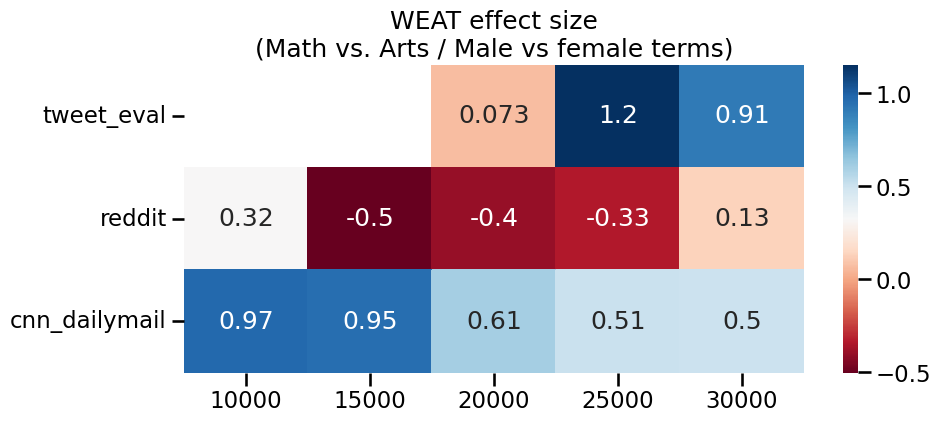

In [44]:
# visualize WEAT scores (technically, effect sizes, which are like Cohen's d) for Math/Arts in heatmap

import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_context('talk')

plt.figure(figsize = (10,4))
sns.heatmap(math_arts.replace('', np.nan).values, annot=True, 
            xticklabels=sizes,
            yticklabels=datasets, cmap = 'RdBu')
plt.title("WEAT effect size\n(Math vs. Arts / Male vs female terms)");

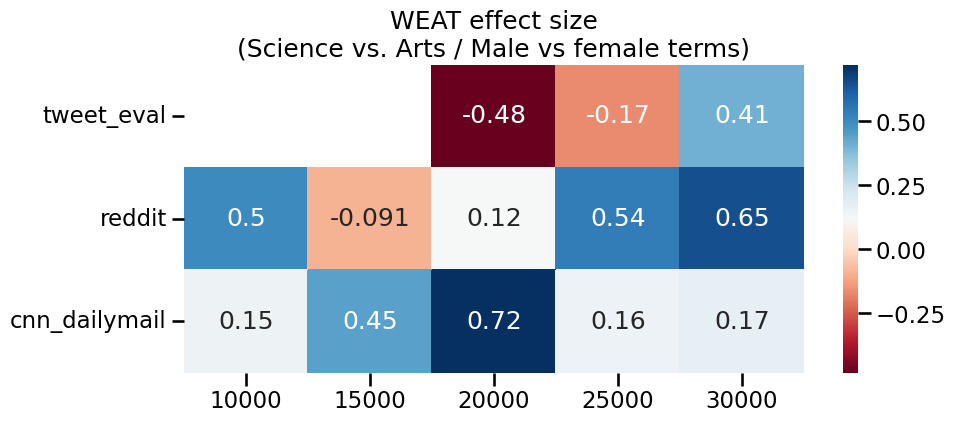

In [45]:
# visualize WEAT scores (technically, effect sizes, which are like Cohen's d) for Science/Arts in heatmap

plt.figure(figsize = (10,4))
sns.heatmap(science_arts.replace('', np.nan).values, annot=True, 
            xticklabels=sizes,
            yticklabels=datasets, cmap = 'RdBu')
plt.title("WEAT effect size\n(Science vs. Arts / Male vs female terms)");

In [46]:
# Compute bad words bias metric 

bad_words_path = "./data/bad-words.txt"
with open(bad_words_path, 'r') as file:
    bad_words = [i[:-1] for i in file.readlines()][1:]

male_words = ['he', 'male', 'man', 'father', 'boy', 'husband']
female_words = ['she', 'female', 'woman', 'mother', 'girl', 'wife']

def calculate_cos_with_badwords(embedding):
    res = {}
    bad_words_invocab = [b for b in bad_words if b in embedding]
    for m, f in zip(male_words, female_words):
        x = [cos_similarity(w, m, embedding) for w in bad_words_invocab]
        y = [cos_similarity(w, f, embedding) for w in bad_words_invocab]
        res[(m,f)] = (x, y)
    return res

def cos_similarity(w1, w2, embedding):
    try:
        e1 = embedding[w1]
        e2 = embedding[w2]
        return (e1*e2).sum()/np.sqrt((e1*e1).sum()*(e2*e2).sum())
    except:
        for w in [w1, w2]:
            if w not in embedding:
                print(f"{w} not in vocab")
        return np.nan

tweet_eval, 10000
Loaded data/tweet_eval_10000_vectors.kv.
tweet_eval, 15000
Loaded data/tweet_eval_15000_vectors.kv.
tweet_eval, 20000
Loaded data/tweet_eval_20000_vectors.kv.
tweet_eval, 25000
Loaded data/tweet_eval_25000_vectors.kv.
tweet_eval, 30000
Loaded data/tweet_eval_30000_vectors.kv.
reddit, 10000
Loaded data/reddit_10000_vectors.kv.
reddit, 15000
Loaded data/reddit_15000_vectors.kv.
reddit, 20000
Loaded data/reddit_20000_vectors.kv.
reddit, 25000
Loaded data/reddit_25000_vectors.kv.
reddit, 30000
Loaded data/reddit_30000_vectors.kv.
cnn_dailymail, 10000
Loaded data/cnn_dailymail_10000_vectors.kv.
cnn_dailymail, 15000
Loaded data/cnn_dailymail_15000_vectors.kv.
cnn_dailymail, 20000
Loaded data/cnn_dailymail_20000_vectors.kv.
cnn_dailymail, 25000
Loaded data/cnn_dailymail_25000_vectors.kv.
cnn_dailymail, 30000
Loaded data/cnn_dailymail_30000_vectors.kv.


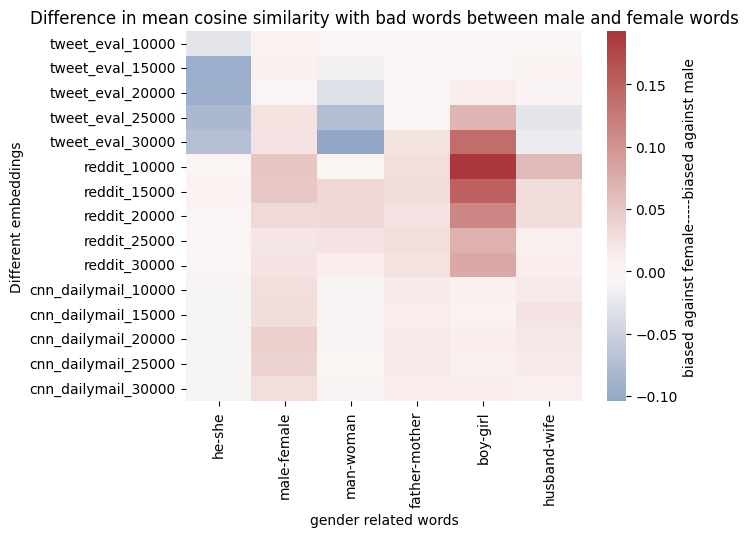

In [47]:
# Plot mean cosine similarity with bad words
import matplotlib
summary_mean_difference = {}
matplotlib.rc_file_defaults()
cmap = sns.color_palette("vlag", as_cmap=True)

for d in datasets:
    for s in sizes:
        print(f"{d}, {s}")
        EMBEDDINGS_FILE = f'data/{d}_{s}_vectors.kv' # file directory of local embeddings file
        word_vectors = KeyedVectors.load(EMBEDDINGS_FILE)
        print(f"Loaded {EMBEDDINGS_FILE}.")
        v = calculate_cos_with_badwords(word_vectors)
        summary_mean_difference[f"{d}_{s}"] = {i:np.nanmean(j[0])-np.nanmean(j[1]) for i,j in v.items()}

df = pd.DataFrame.from_dict(summary_mean_difference, orient='index')
sns.heatmap(df, cmap=cmap, center=0, cbar_kws={'label': 'biased against female-----biased against male'})
plt.xlabel('gender related words')
plt.ylabel('Different embeddings')
plt.title('Difference in mean cosine similarity with bad words between male and female words')
plt.show()